In [1]:
import os

# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 0"  # Set the GPUs 2 and 3 to use

In [2]:
from dataset import BratsDataset
import os
import nibabel as nib
import numpy as np
from utils import get_dataloader
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'ch3_32_interval_3_240'
_model = torch.load(os.path.join('models', model_name, f"{model_name}.pth"))
_model = _model.to(device)
model = nn.DataParallel(_model).to(device)
model.eval()

test_dataloader = get_dataloader(dataset=BratsDataset, phase="test", img_depth=64, img_width=240, 
                                data_type=
                                ["-t1n.nii.gz",
                                 "-t1c.nii.gz",
                                 #   "-t2w.nii.gz",
                                "-t2f.nii.gz"], batch_size=1)


In [3]:
test_batch = next(iter(test_dataloader))
batch_id, images, targets = test_batch['Id'], test_batch['image'], test_batch['mask']
images = images.to(device)
targets = targets.to(device)
print('batch id',batch_id)
print('loaded image, target shape',images.shape, targets.shape)
targets = targets[0]
targets = targets.detach().cpu().numpy()

batch id ['BraTS-GLI-00237-000']
loaded image, target shape torch.Size([1, 3, 52, 240, 240]) torch.Size([1, 3, 155, 240, 240])


In [4]:
logits = model(images)
logits.shape

torch.Size([1, 3, 155, 240, 240])

In [5]:
pred = torch.sigmoid(logits).detach().cpu().numpy()
pred = (pred>=0.33).astype(int)
pred.shape

(1, 3, 155, 240, 240)

In [6]:
targets.shape

(3, 155, 240, 240)

In [7]:
from eval_utils import compute_dice
compute_dice(pred[0], targets)

0.9374063770597046

In [8]:
import matplotlib.pyplot as plt
def comp_gt_pred(gt, pred, slide2show):
    classes = ['WT', 'TC', 'ET']
    for i,clas in enumerate(classes):
        plt.subplot(2,3,i+1)
        plt.title(f'GT of {clas}')
        plt.imshow(gt[i][slide2show], cmap='gray')
        plt.axis('off')
        plt.subplot(2,3,i+1+3)
        plt.title(f'prediction of {clas}')
        plt.axis('off')
        plt.imshow(pred[i][slide2show], cmap='gray')
    plt.show()

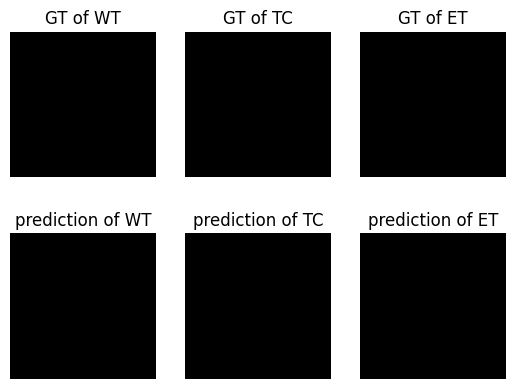

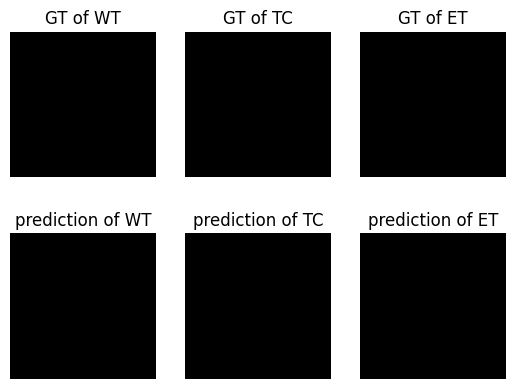

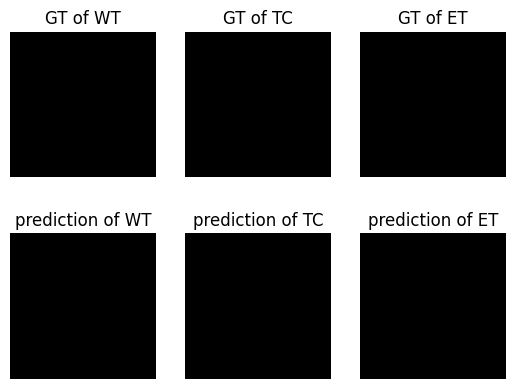

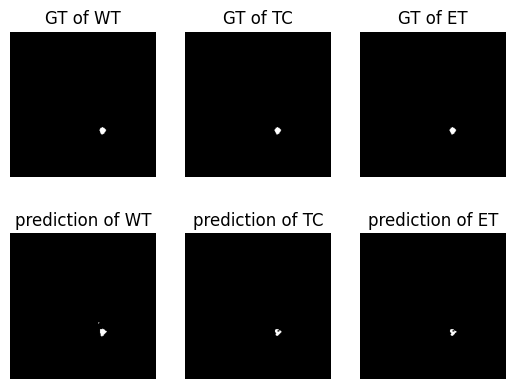

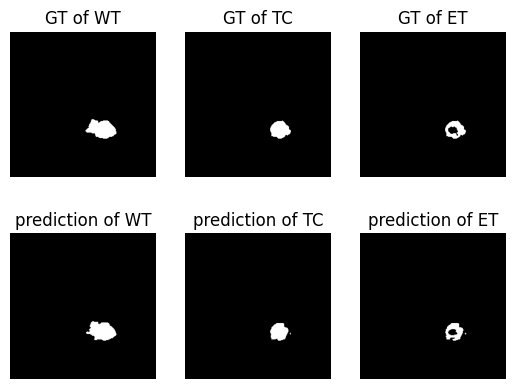

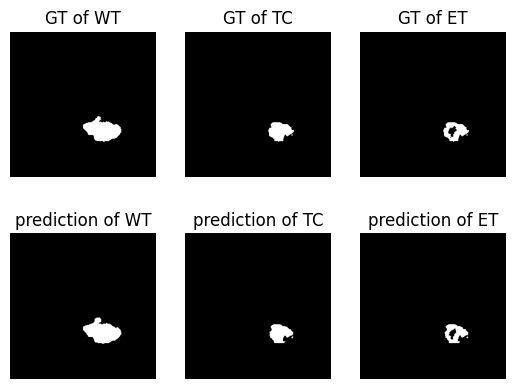

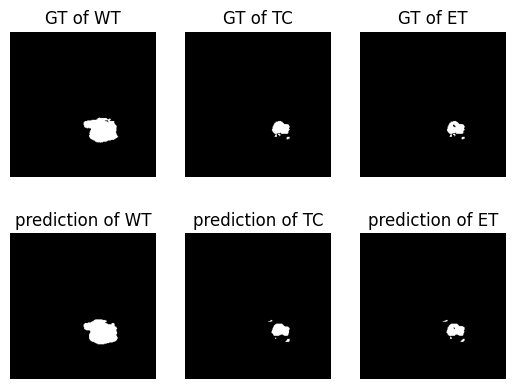

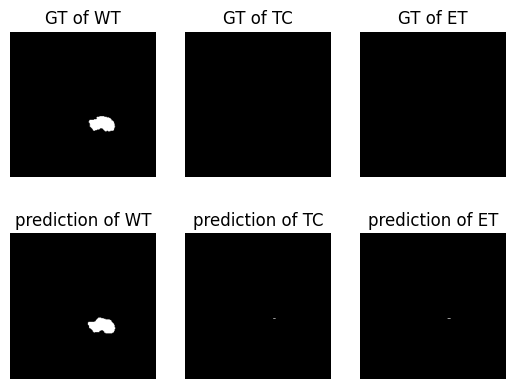

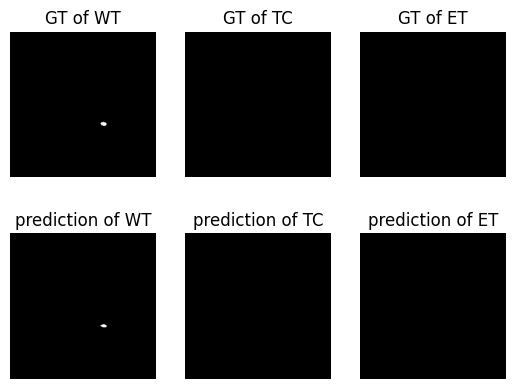

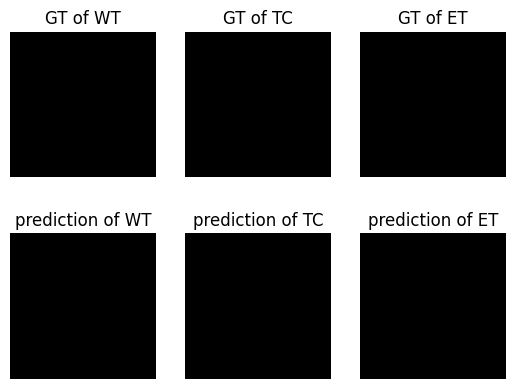

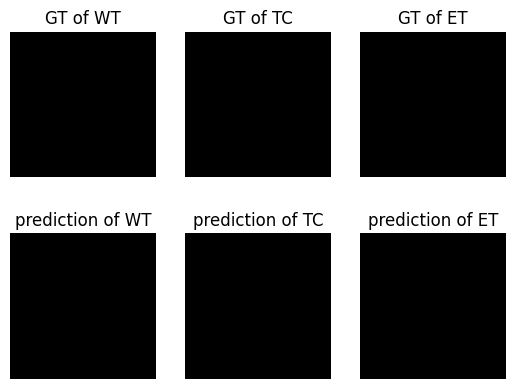

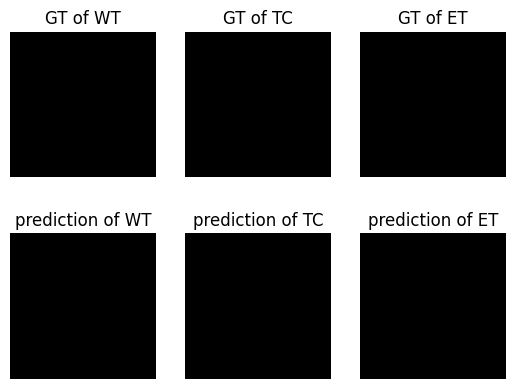

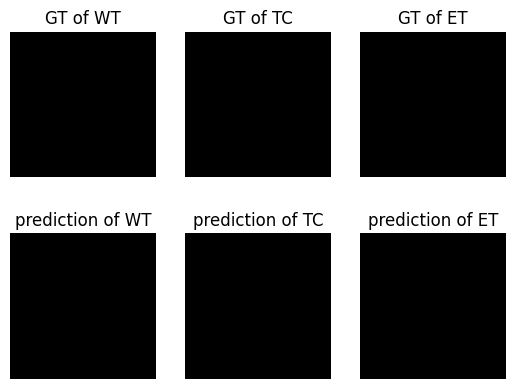

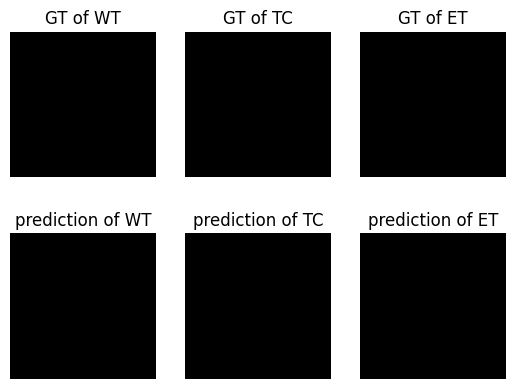

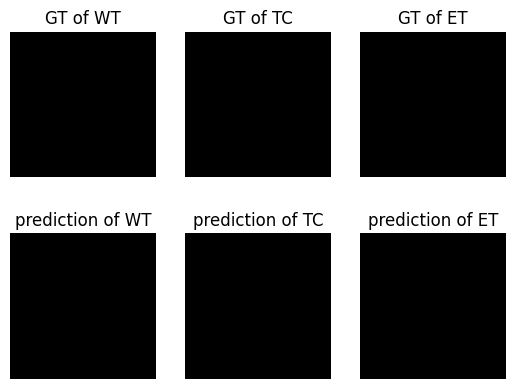

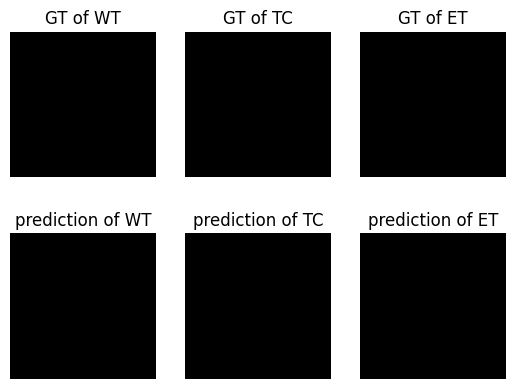

In [9]:
for i in range(0,155,10):
    comp_gt_pred(targets, pred[0], i)

In [12]:
for i, img in enumerate(pred[0][0]):
    if(len(np.nonzero(img)[0])==0):
        print(i, 'empty')

0 empty
1 empty
2 empty
3 empty
4 empty
5 empty
6 empty
7 empty
8 empty
9 empty
10 empty
11 empty
12 empty
13 empty
14 empty
15 empty
16 empty
17 empty
18 empty
19 empty
20 empty
21 empty
22 empty
23 empty
24 empty
25 empty
26 empty
27 empty
81 empty
82 empty
83 empty
84 empty
85 empty
86 empty
87 empty
88 empty
89 empty
90 empty
91 empty
92 empty
93 empty
94 empty
95 empty
96 empty
97 empty
98 empty
99 empty
100 empty
101 empty
102 empty
103 empty
104 empty
105 empty
106 empty
107 empty
108 empty
109 empty
110 empty
111 empty
112 empty
113 empty
114 empty
115 empty
116 empty
117 empty
118 empty
119 empty
120 empty
121 empty
122 empty
123 empty
124 empty
125 empty
126 empty
127 empty
128 empty
129 empty
130 empty
131 empty
132 empty
133 empty
134 empty
135 empty
136 empty
137 empty
138 empty
139 empty
140 empty
141 empty
142 empty
143 empty
144 empty
145 empty
146 empty
147 empty
148 empty
149 empty
150 empty
151 empty
152 empty
153 empty
154 empty


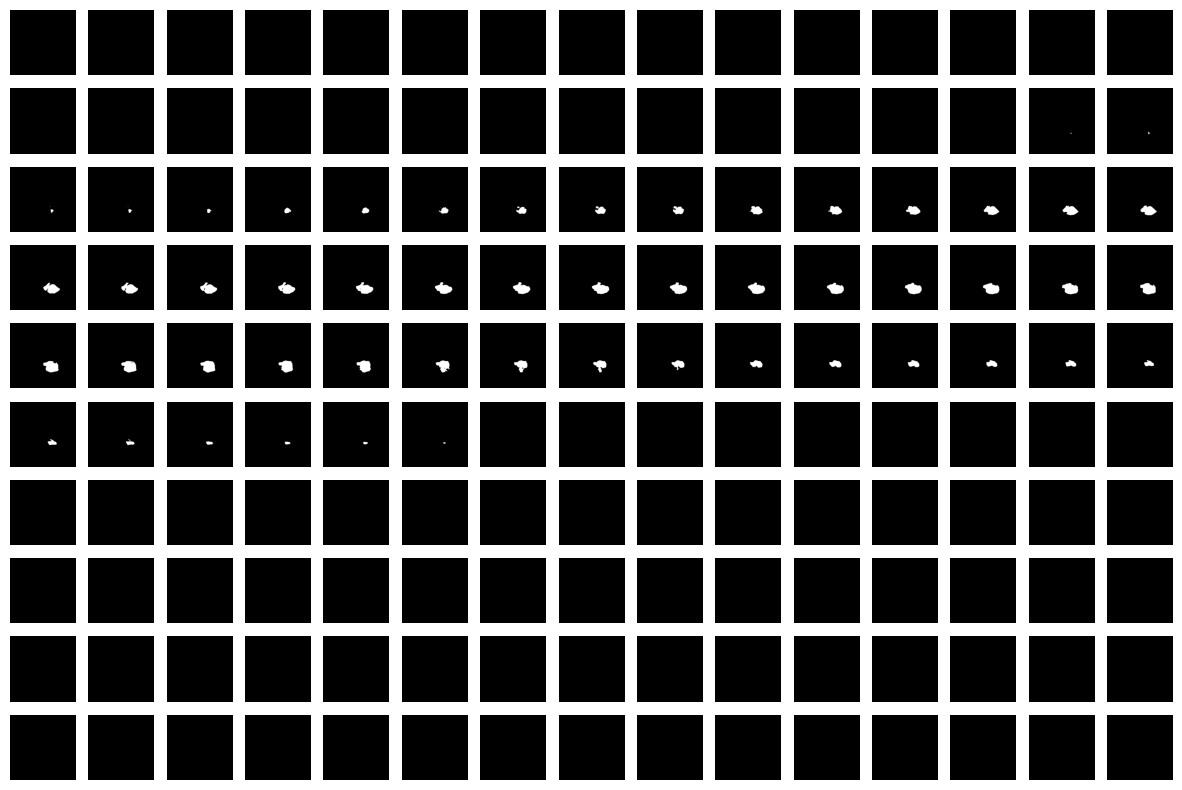

In [13]:
plt.figure(figsize=(15,10))
for i, img in enumerate(pred[0][0][:150]):
    plt.subplot(10,15,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [16]:
id = batch_id[0]
id

'BraTS-GLI-00237-000'

In [18]:
classes = ['WT', 'TC', 'ET']
for class_idx in range(3):
    clas = classes[class_idx]
    for i, img in enumerate(pred[0][class_idx]):
        if len(np.nonzero(img)[0]) != 0:
            plt.imsave(f'inference_res_fig/{model_name}/{clas}/{id}-{clas}-{i:03d}.png', img,cmap='gray')